# Multiclass classification

## Introduction

In this notebook, we will perform a multiclass classification analysis using large language models (LLMs). 
Multiclass classification refers to the task of categorizing data entries into one of three or more predefined categories, as opposed to binary classification, which involves only two categories.

The dataset should be formatted with one row per entry, ensuring that each entry represents a single instance of data. One column is designated as a unique identifier, which allows for later comparisons between the results from LLM analysis and human annotations.

### Dataset Description

The dataset used in this notebook is an anonymized subset from the study available at https://doi.org/10.1007/s40593-023-00340-7. In the original experiment, children were asked to read a text and then pose a question related to it. The questions were subsequently categorized into three distinct types:

- Answerable from the text: Questions where the answer could be directly found in the text.
- Inferable from the text: Questions where the answer could be inferred but required deeper understanding or reasoning based on the text.
- Not answerable by the text: Questions where the answer could not be derived from the text at all.

In the example dataset:
- **Reference Text**: A column containing the text that children were asked to read beforehand.
- **Question**: A column containing the questions posed by the children after reading the reference text.

To classify a question, both the reference text and the question itself are required, as the classification depends on the relationship between the two.

Additionally, the dataset includes ratings from three different human annotators. These ratings allow us to compute inter-annotator agreement, such as Cohen's kappa, once the analysis is complete.

## Import the libraries

In [1]:
import os
import pandas as pd
from qualitative_analysis import (
    load_data,
    clean_and_normalize,
    sanitize_dataframe,
    get_llm_client,
    compute_all_kappas,
    plot_confusion_matrices,
    process_verbatims_for_multiclass_criteria,
)
import qualitative_analysis.config as config

## Load the data

To begin, we need to load the dataset, which is stored in the `data` folder located in the project's root directory.

In this step, we define the data directory and the file path for the dataset. We then load the data and preview the first few rows to get an overview of the dataset's structure and content.

In [2]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Define the path to your dataset
data_file_path = os.path.join(data_dir, 'multiclass_sample.csv')

# Load the data
data = load_data(data_file_path, file_type='csv', delimiter=';')

# Preview the data
data.head()

,q_index,text,question,div_rater1,div_rater2,div_rater3
0,196,Les énormes yeux des insectes font quasiment l...,Pourquoi ces petits yeux sont chargés de trait...,2,2,2
1,197,Les énormes yeux des insectes font quasiment l...,Comment les point sont ensuite assemblés,2,2,0
2,198,Les énormes yeux des insectes font quasiment l...,C'est quoi un casque de vision 3D ?,2,2,2
3,199,Les énormes yeux des insectes font quasiment l...,Combien d'yeux petits ont les humains en moyen...,2,2,2
4,200,Les énormes yeux des insectes font quasiment l...,Quel être vivant a le plus de petis yeux ?,1,1,2


## Data Preprocessing

In this step, we preprocess the dataset to ensure it is ready for analysis. The operations include:

1. **Rename Columns** (optional): Rename the original column names to more descriptive ones for clarity.
2. **Define Text Columns**: Identify the columns containing textual data (here `text` and `question`) for further cleaning.
3. **Clean and Normalize Text**: Apply a cleaning function to normalize and standardize the text data in the identified columns.
4. **Sanitize the DataFrame**: Remove any newline or carriage return characters from string columns to ensure consistent formatting across the dataset.

These preprocessing steps prepare the data for analysis.

In [3]:
# 1a) Define a mapping from old column names to new names
# rename_map = {
#     "ref": "reference",
#     "txt1.ctrl1": "Identify",
#     "txt1.det": "Guess",
#     "txt1.exp": "Seek",
#     "txt1.ctrl2": "Assess"
# }

# # 1b) Rename the columns in the DataFrame
# data = data.rename(columns=rename_map)

# 2) Now define the new column names for cleaning
text_columns = ["text", "question"]

# 3) Clean and normalize the new columns
for col in text_columns:
    data[col] = clean_and_normalize(data[col])

# 4) Sanitize the DataFrame
data = sanitize_dataframe(data)


## Combine Texts and Questions

Then, we combine the reference texts and questions into a single formatted string for each row called **verbatim**, making it easier to process and analyze.

In [4]:
# Combine texts and entries

data['verbatim'] = data.apply(
    lambda row: (
        f"Text: {row['text']}\n\n"
        f"Question: {row['question']}"
    ),
    axis=1
)

# Extract the list of verbatims
verbatims = data['verbatim'].tolist()

print(f"Total number of verbatims: {len(verbatims)}")
print(f"Verbatim example:\n{verbatims[0]}")

Total number of verbatims: 107
Verbatim example:
Text: Les enormes yeux des insectes font quasiment le tour de leurs tetes. Ils voient donc en meme temps vers lavant, vers larriere, a droite, a gauche, vers le haut et vers le bas. Encore mieux quun casque de vision en 3D! En revanche, ils ne voient pas tres net, parce que leur il est constitue de centaines, ou meme de milliers de petits yeux simples. Chacun de ces petits yeux est charge de traiter une toute petite partie de lenvironnement. Un petit il produit un simple point dune teinte et dune intensite lumineuse donnees. Ces points sont ensuite assembles les uns aux autres dans le cerveau de linsecte pour former une image complete et unique. Un il dune abeille contient 4500 petits yeux. Celui dune libellule en a 15000: cest l'il le plus complexe chez les insectes !

Question: Pourquoi ces petits yeux sont charges de traiter une petite partie de l'environnement ?


## Choose the LLM

In this step, we initialize the client to interact with a specific large language model (LLM) provider.
This setup enables communication with the chosen language model.

For OpenAI models use the openai API, for open-source models use the TogetherAI API.

OpenAI models: https://platform.openai.com/docs/models

TogetherAI models: https://docs.together.ai/docs/chat-models

In [5]:
# Choose the provider and model
provider = 'azure'
model_name = 'gpt-4o-mini'

# Initialize the client
llm_client = get_llm_client(provider=provider, config=config.MODEL_CONFIG[provider])

## Prompt Construction and Classification

In this step, we define the logic for constructing prompts and processing data for multiclass classification using LLMs. The structure of the prompt provided to the LLM includes:

1. **Column Descriptions**:  
   A brief explanation of the dataset columns to clarify their roles.

2. **Codebook**:  
   Clear instructions for the classification task, written as if you were explaining the task to a human annotator.

3. **Examples (Optional)**:  
   Include illustrative examples (not included in the dataset) formatted to demonstrate the desired classification approach, guiding the LLM in the classification process.

4. **Verbatims**:  
   The specific reference text and question from the dataset to be classified.

### Classification Settings
- **Reasoning**:  
  - `reasoning = False`: A single-step classification where the LLM directly returns a classification label (e.g., `0`, `1`, or `2`). This uses only the multiclass query.  
  - `reasoning = True`: A two-step process where the LLM first generates a reasoning statement (based on the reasoning query). The reasoning, combined with the initial prompt and multiclass query, is used to determine the classification label. This requires two LLM calls per entry.

- **Valid Scores**:  
  `valid_scores = [0, 1, 2]`: The list of possible classification labels, which can be adjusted to match the specific requirements of the task.

In [6]:
# Define instructions for multiclass classification
# Classification settings
reasoning = True  # If True, perform two-step reasoning. If False, single-step classification.
verbose = False # If True, show the prompt

# Define valid scores (modifiable in the notebook)
valid_scores = [0, 1, 2]  # You can change this to any list of valid scores

# Select subset of verbatims for testing
subset = 5
verbatims_subset = verbatims[:subset]

codebook = {
"Classification de divergence":

"""Codebook:

Les données se composent d'un texte de référence et d'une question posée par un enfant.
Vous devez classer la question dans l'une des catégories suivantes :

0 : la réponse à la question est indiquée dans le texte.
1 : la réponse à la question n'est pas explicitement indiquée dans le texte, mais peut être déduite ou devinée à partir du texte.
2 : la réponse à la question n'est pas du tout indiquée dans le texte.

Les erreurs mineures d'orthographe, de grammaire ou de formulation ne doivent pas être pénalisées tant que l'intention de l'entrée est claire et respecte les critères d'inclusion. Concentrez-vous sur le contenu et l'objectif de l'entrée plutôt que sur la perfection linguistique.

Exemples:

Exemple 1
Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
Question: Quand est-elle née ?
Réponse: 2

Exemple 2
Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
Question: Marie a-t-elle passé toute sa vie en Pologne ?
Réponse: 0

Exemple 3
Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
Question: Qui est Pierre Curie ?
Réponse: 1
"""
}

# Define column descriptions
column_descriptions = (
    "Texte: Le texte de référence\n"
    "Question: La question de l'enfant."
)

# Define queries for multiclass classification and reasoning
multiclass_query = "Répondez uniquement avec le chiffre de classification, rien d'autre."
reasoning_query = "Générez un raisonnement d'une seule phrase à propos de la classification (ne donnez pas le label de classification)." # used only if reasoning = True

# To be sure to have an integer only when doing 1 call request
command = (
    "Votre réponse ne doit contenir que le chiffre de classification, rien d'autre."
    if not reasoning
    else ""
)

prompt_template = f"""
Vous êtes un assistant utile chargé d'évaluer l'entrée suivante :

Entrée:
{{verbatim_text}}

Vous devez l'évaluer de la sorte :
{{codebook}}
Les données sont au format suivant :
{column_descriptions}

{command}
"""

# Process verbatims using the externalized function
results, verbatim_costs = process_verbatims_for_multiclass_criteria(
    verbatims_subset=verbatims_subset,
    codebooks=codebook,
    llm_client=llm_client,
    model_name=model_name,
    prompt_template=prompt_template,  
    multiclass_query=multiclass_query,
    reasoning_query=reasoning_query,
    valid_scores=valid_scores,
    reasoning=reasoning,
    verbose=verbose
)

# Print final multiclass results
for result in results:
    print(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)


=== Processing Complete ===
Total Tokens Used: 10146
Total Cost for Processing: $0.0017
{'Text': "Les enormes yeux des insectes font quasiment le tour de leurs tetes. Ils voient donc en meme temps vers lavant, vers larriere, a droite, a gauche, vers le haut et vers le bas. Encore mieux quun casque de vision en 3D! En revanche, ils ne voient pas tres net, parce que leur il est constitue de centaines, ou meme de milliers de petits yeux simples. Chacun de ces petits yeux est charge de traiter une toute petite partie de lenvironnement. Un petit il produit un simple point dune teinte et dune intensite lumineuse donnees. Ces points sont ensuite assembles les uns aux autres dans le cerveau de linsecte pour former une image complete et unique. Un il dune abeille contient 4500 petits yeux. Celui dune libellule en a 15000: cest l'il le plus complexe chez les insectes !", 'Question': "Pourquoi ces petits yeux sont charges de traiter une petite partie de l'environnement ?", 'Theme': 'Classificati

## Saving the Results

This step provides an option to save the classification results to a file for future reference or further analysis.

In [11]:
# Possibility to save the results

# import datetime
# # Define the save path
# outputs_dir = os.path.join(data_dir, 'outputs')
# os.makedirs(outputs_dir, exist_ok=True)
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# save_path = os.path.join(
#     outputs_dir, 
#     f"experiment_{model_name.replace('/', '_')}_{timestamp}.xlsx" 
# )

# # Save the DataFrame to Excel
# try:
#     results_df.to_excel(save_path, index=False, sheet_name='Results')
#     print(f"Results successfully saved to: {save_path}")
# except Exception as e:
#     print(f"An error occurred while saving the Excel file: {e}")

## Evaluating Model Performance Against Human Annotations

### Computing Cohen's Kappa

In this step, we compare the model's classifications with human annotations using Cohen's Kappa.

1. **Unweighted Kappa**:  
   All disagreements are treated equally, regardless of the "distance" between the categories. For example, a mismatch between `0` and `1` is penalized the same as a mismatch between `0` and `2`.

2. **Linear Weights**:  
   With `weights='linear'`, disagreements are penalized proportionally to their distance. For instance:
   - A mismatch between `0` and `1` incurs a smaller penalty than a mismatch between `0` and `2`.
   - This approach is suitable when the categories have a natural ordering (e.g., `0 < 1 < 2`) but the differences are not exponential.

3. **Quadratic Weights**:  
   With `weights='quadratic'`, disagreements are penalized more heavily as the distance increases. This approach emphasizes larger disagreements even more than linear weights.



In [12]:
# Assuming you have human annotations in the data
model_coding = results_df['Label'].tolist()
model_coding = [int(x) for x in model_coding]

human_annotations = {
    'div_rater1': [int(x) for x in data['div_rater1'].tolist()],
    'div_rater2': [int(x) for x in data['div_rater2'].tolist()],
    'div_rater3': [int(x) for x in data['div_rater3'].tolist()],
}

# Shorten data for demonstration if needed
model_coding_short = model_coding[:subset]
human_annotations_short = {rater: ann[:subset] for rater, ann in human_annotations.items()}

# Compute Cohen's Kappa for all pairings and print results
kappa_results = compute_all_kappas(
    model_coding_short,
    human_annotations_short,
    labels=[0, 1, 2],
    weights='linear',
    verbose=True
)

Model vs div_rater1: 0.07
Model vs div_rater2: 0.07
Model vs div_rater3: 0.29
div_rater1 vs div_rater2: 1.00
div_rater1 vs div_rater3: -0.15
div_rater2 vs div_rater3: -0.15


### Visualizing Agreement

In this step, we plot confusion matrices to visualize the agreement between the model's classifications and human annotations, or between two human annotations.

**Inputs**:
- `model_coding_short`: The model's predictions for the subset of data.
- `human_annotations_short`: The annotations from human raters for the same subset.

**Labels**:
- `[0, 1, 2]`: The three classification categories representing:
   - `0`: The answer is explicitly in the text.
   - `1`: The answer can be inferred from the text.
   - `2`: The answer is not in the text at all.


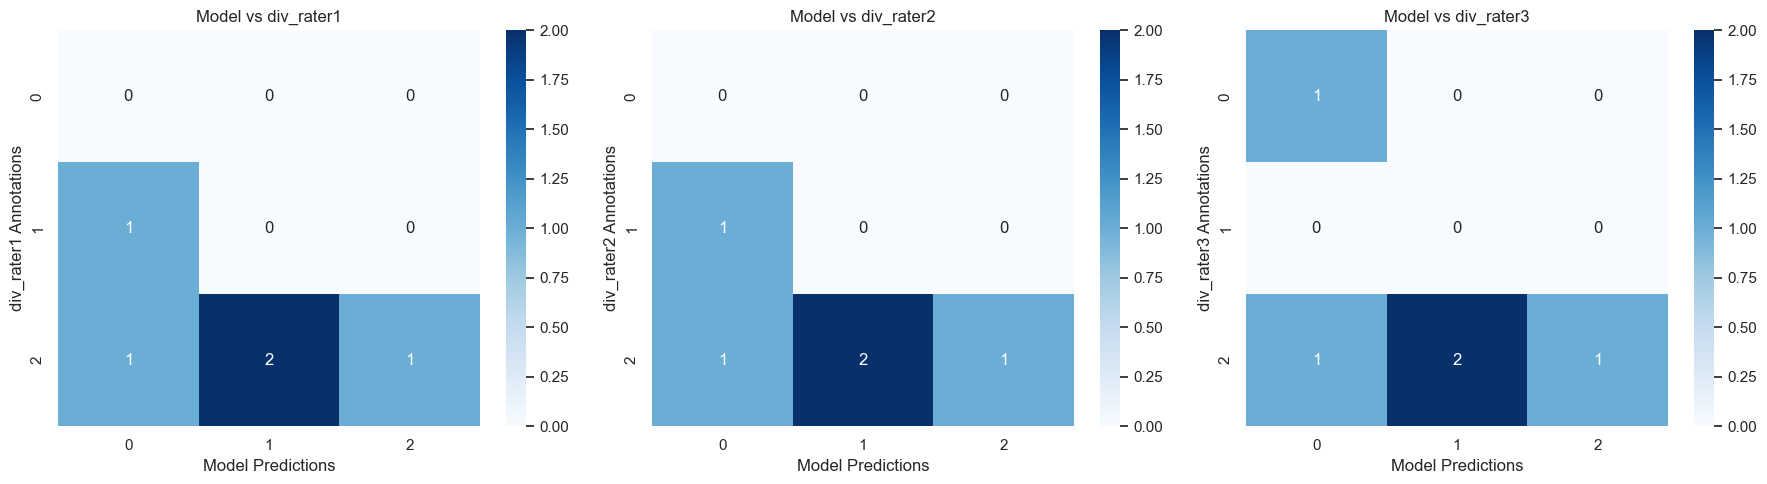

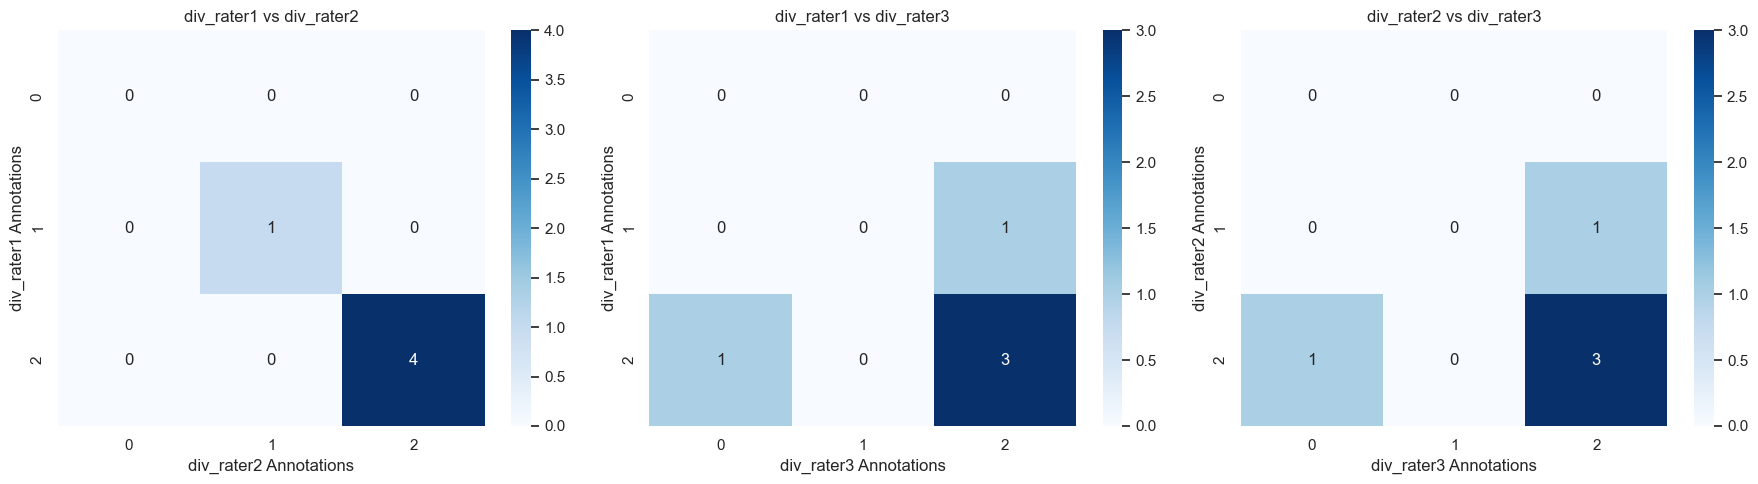

In [13]:
# Plot confusion matrices for all comparisons
plot_confusion_matrices(model_coding_short, human_annotations_short, labels=[0, 1, 2])